# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов. Вы будете классифицировать тксты писателей по авторству. Всего 8 разных авторов.

Скачаем датасет:

In [62]:
!wget -O train_authors.csv https://raw.githubusercontent.com/MSUcourses/Data-Analysis-with-Python/main/Deep%20Learning/Files/train_authors.csv

--2024-04-13 20:34:52--  https://raw.githubusercontent.com/MSUcourses/Data-Analysis-with-Python/main/Deep%20Learning/Files/train_authors.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4883974 (4.7M) [text/plain]
Saving to: ‘train_authors.csv’

train_authors.csv   100%[===================>]   4.66M  --.-KB/s    in 0.09s   

2024-04-13 20:34:52 (51.0 MB/s) - ‘train_authors.csv’ saved [4883974/4883974]



In [63]:
!wget -O test_authors.csv https://raw.githubusercontent.com/MSUcourses/Data-Analysis-with-Python/main/Deep%20Learning/Files/test_authors.csv

--2024-04-13 20:34:53--  https://raw.githubusercontent.com/MSUcourses/Data-Analysis-with-Python/main/Deep%20Learning/Files/test_authors.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4871403 (4.6M) [text/plain]
Saving to: ‘test_authors.csv’

test_authors.csv    100%[===================>]   4.65M  --.-KB/s    in 0.02s   

2024-04-13 20:34:53 (275 MB/s) - ‘test_authors.csv’ saved [4871403/4871403]



Импортируем необходимые библиотеки:

In [64]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk
from tqdm import tqdm_notebook
import torch.nn as nn                                                             # тут все блоки нейронных сетей, слои
import torch.nn.functional as F

from collections import Counter
from typing import List
import string

import seaborn

# скачиваем нужный пакет данных для работы библиотеки nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [65]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Загрузим даатсет и посмотрим на данные:

In [66]:
# Загрузим датасет


Здесь поле 'text' — это текст, а 'label' — автор текста. 'label' — это целевая переменная, которую мы будем предсказывать. Обратите внимания, что в тестовых данных столбца 'label' нет, вам нужно будет предсказать его значения и отправить в качестве ответа на Яндекс.Контест.

In [67]:
import pandas as pd
train_data = pd.read_csv('train_authors.csv')
train_data.head()
test_data = pd.read_csv('test_authors.csv')
test_data.head()
writers = ['Akunin', 'Bulychev', 'Chehov', 'Dostoevsky', 'Gogol', 'King',
       'Pratchett', 'Remark']
writers_to_label = {writer: i for i, writer in enumerate(writers)}
label_to_writers = {i: writer for i, writer in enumerate(writers)}

Заведем словарь соответствия имени автора его номеру:

Создадим словарь dataset, который будет устроен так же, как переменная dataset в ноутбуке занятия. В тестовой части (dataset['test']) зададим для удобства всем текстам label=0.

Ваша задача — обучить RNN-модель на тренировочных данных и получить максимальное возможное accuracy на тестовой части данных. За основу можно взять код с занятия. **Обратите внимание, что здесь у нас задача классификации на 8 классов, а не на 2, как было на занятии.**

Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Вот несколько идей:
* **Модель RNN**. Попробуйте LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее.
* **Изменение вида агрреграции выхода RNN**. В семинаре мы пробовали аггрегировать выходы RNN с помощью max, mean и получения последнего выхода. Можно попробовать другие варианты. Например, конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Можно, например, увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

In [68]:
# HYPERPARAMETRS

counter_threshold = 25

batch_size = 128

max_len_batch_elems = 200

In [69]:
def collate_fn_with_padding(input_batch, max_len=max_len_batch_elems):
    # input_batch — батч пар (токенизированный текст, label)
    texts = [x['text'] for x in input_batch]
    labels = [x['label'] for x in input_batch]
    # для каждого элемента батча получаем длину токенизированного текста в токенах
    seq_lens = [len(x) for x in texts]
    # определяем максимальную длину элементов в текущем батче
    max_seq_len = min(max(seq_lens), max_len)

    # проходимся по элементам батча и заменяем токены на их индексы из словаря
    # также последовательности короче max_seq_len дополняем токенами <pad>
    processed_texts = []
    for text, label in zip(texts, labels):
        text = text[:max_seq_len]
        text = [word2ind[x] if x in vocab else word2ind['<unk>'] for x in text]
        for _ in range(max_seq_len - len(text)):
            text.append(word2ind['<pad>'])

        processed_texts.append(text)

    # переводим элементы батча в форматы тензоров
    processed_texts = torch.LongTensor(processed_texts).to(device)
    labels = torch.LongTensor(labels).to(device)

    # собираем батч
    processed_batch = {
        'input_ids': processed_texts,
        'label': labels
    }

    return processed_batch

def token_text(text):
  return word_tokenize(text.lower())
# TODO: попробовать убрать пунктуацию

def evaluate(model, dataloader):
    """
    Calculate accuracy on data from dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in tqdm_notebook(dataloader,
                                   desc=f'Evaluating'):
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

def train(model, optimizer, criterion, num_epoch=5, eval_steps=100):

    losses = []
    accs_train = []
    accs_val = []

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm_notebook(train_dataloader,
                                                desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                accs_train.append(evaluate(model, train_dataloader))
                accs_val.append(evaluate(model, val_dataloader))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    return losses, accs_train, accs_val

In [70]:
dataset = {}

dataset['train'] = [{'text':text, 'label':writers_to_label[label]} \
              for text, label in zip(np.array(train_data['text']), np.array(train_data['label']))]
dataset['test'] = [{'text':text, 'label': 0} \
              for text in np.array(test_data['text'])]



for i, text in enumerate(dataset['train']):
  dataset['train'][i]['text'] = token_text(text['text'])
for i, text in enumerate(dataset['test']):
  dataset['test'][i]['text'] = token_text(text['text'])


words = Counter()

for text in dataset['train']:
  for word in text['text']:
    words[word] += 1

In [71]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [72]:
np.random.seed(42)
val_indices = np.random.choice(np.arange(len(dataset['test'])), 600)
test_indices = [x for x in range(len(dataset['test'])) if x not in val_indices]
val_data = [dataset['test'][i] for i in val_indices]
test_data = [dataset['test'][i] for i in test_indices]
train_data = dataset['train']

# заводим даталоадеры
train_dataloader = DataLoader(
    train_data, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

val_dataloader = DataLoader(
    val_data, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_data, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [75]:
class SimpleRNN(nn.Module):
    def __init__(
        self, hidden_dim, vocab_size, num_classes,
        aggregation_type: str = 'last'
        ):
        super().__init__()
        # слой эмбеддинга
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        # рекуррентный слой
        self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers=1, batch_first=True, dropout=0.1)#, bidirectional=True)
        # два полносвязных слоя
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

        # слой дропаут
        self.dropout = nn.Dropout(p=0.3)

        # каким образом выходы RNN-слоя для разных моментов времени будут
        # агрегироваться перед подачей дальше на вход полносвязному слою
        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)          # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0]         #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1)           #[batch_size, hidden_dim]
        elif self.aggregation_type == 'last':
            output = output[:, -1, :]
        else:
            raise ValueError("Invalid aggregation_type")

        output = F.tanh(output)
        output = F.tanh(self.dropout(self.fc1(output)))   # [batch_size, hidden_dim]
        output = self.fc2(output)                         # [batch_size, num_classes]

        return output

In [76]:
num_epoch = 10
eval_steps = len(train_dataloader) // 2


losses_type = {}
accs_train_type = {}
accs_val_type = {}

for aggregation_type in ['max', 'mean', 'last']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = SimpleRNN(hidden_dim=max_len_batch_elems,
                      vocab_size=len(vocab),
                      num_classes=8,
                      aggregation_type=aggregation_type
                      ).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    losses, accs_train, accs_val = train(model,
                                         optimizer,
                                         criterion,
                                         num_epoch=5,
                                         eval_steps=len(train_dataloader) // 2)

    losses_type[aggregation_type] = losses
    accs_train_type[aggregation_type] = accs_train
    accs_val_type[aggregation_type] = accs_val

Starting training for max


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
<ipython-input-69-38f1c71803d9>:66: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(train_dataloader,


Training epoch 0::   0%|          | 0/13 [00:00<?, ?it/s]

<ipython-input-69-38f1c71803d9>:45: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm_notebook(dataloader,


Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Starting training for last


Training epoch 0::   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

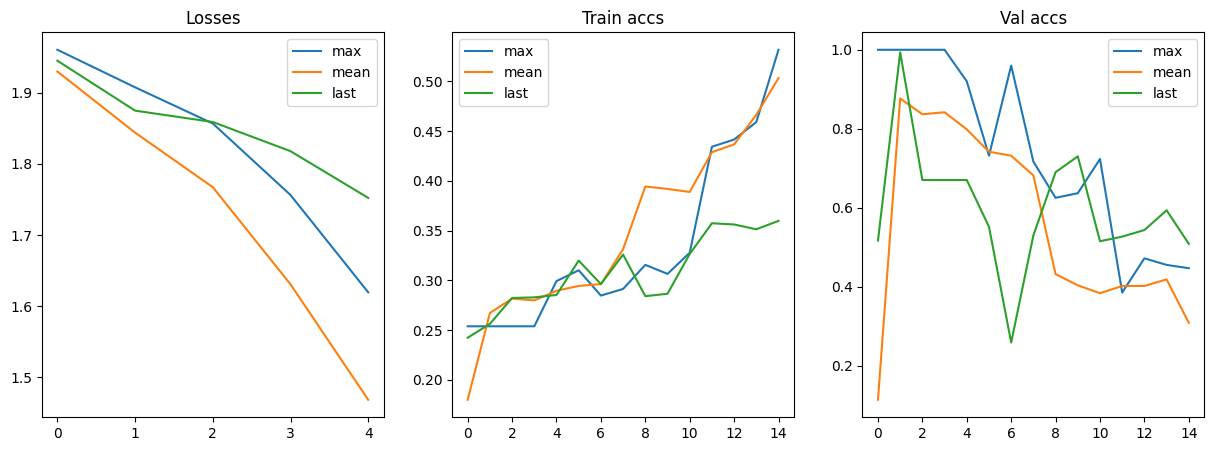

In [77]:
plt.figure(figsize=(15,5))

plt.subplot(131)
for aggregation_type in ['max', 'mean', 'last']:
    plt.plot(losses_type[aggregation_type])
plt.title('Losses')
plt.legend(['max', 'mean', 'last'])

plt.subplot(132)
for aggregation_type in ['max', 'mean', 'last']:
    plt.plot(accs_train_type[aggregation_type])
plt.title('Train accs')
plt.legend(['max', 'mean', 'last'])

plt.subplot(133)
for aggregation_type in ['max', 'mean', 'last']:
    plt.plot(accs_val_type[aggregation_type])
plt.title('Val accs')
plt.legend(['max', 'mean', 'last'])

## Сдача задания

Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы получить предсказания на тестовой выборке. Здесь model — ваша обученная модель, dataloader — test_dataloader, построенный на основе тестовой части данных (dataset['test']):

In [ ]:
def get_predictions(model, dataloader):
    """
    Calculate accuracy on data from dataloader.
    """

    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in tqdm_notebook(dataloader,
                                   desc=f'Evaluating'):
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))

    predictions = torch.cat(predictions).data.cpu().numpy()

    return predictions

In [ ]:
predictions = get_predictions(model, test_dataloader)
predictions = [label_to_writers[x] for x in predictions]
predictions

In [ ]:
np.save('submission_hw07.npy', predictions, allow_pickle=True)
print('Ответ сохранен в файл `submission_hw07.npy`')